In [2]:
!pip install d2l

     |████████████████████████████████| 83 kB 1.5 MB/s 


In [3]:
import pandas as pd
import numpy as np
import torch
from d2l import torch as d2l
from torch import nn

In [4]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [7]:
df_train.head

<bound method NDFrame.head of         Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0        1          60       RL  ...        WD         Normal    208500
1        2          20       RL  ...        WD         Normal    181500
2        3          60       RL  ...        WD         Normal    223500
3        4          70       RL  ...        WD        Abnorml    140000
4        5          60       RL  ...        WD         Normal    250000
...    ...         ...      ...  ...       ...            ...       ...
1455  1456          60       RL  ...        WD         Normal    175000
1456  1457          20       RL  ...        WD         Normal    210000
1457  1458          70       RL  ...        WD         Normal    266500
1458  1459          20       RL  ...        WD         Normal    142125
1459  1460          20       RL  ...        WD         Normal    147500

[1460 rows x 81 columns]>

In [8]:
df_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [13]:
X = pd.concat((df_train.iloc[:, 1:-1], df_test.iloc[:, 1:]))

In [23]:
numeric_X = X.dtypes[X.dtypes!='object'].index
X[numeric_X] = X[numeric_X].apply(lambda x: (x-x.mean()/(x.std())))
X[numeric_X] = X[numeric_X].fillna(0)

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   float64
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   float64
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   float64
 17  OverallCond    2919 non-null   float64
 18  YearBuil

In [25]:
X = pd.get_dummies(X, dummy_na=True)
X.shape

(2919, 331)

In [98]:
n_train = df_train.shape[0]
n_test = df_test.shape[0]
X_train = torch.tensor(X.iloc[:n_train,:].values, dtype=torch.float32)
X_test = torch.tensor(X.iloc[n_train:, :].values, dtype=torch.float32)
y_train = torch.tensor(df_train['SalePrice'].values.reshape(-1,1), dtype=torch.float32)

In [97]:
X_train.size()

torch.Size([1460, 331])

In [70]:
loss = nn.MSELoss()
num_inputs = X_train.shape[1]
def get_net():
  net = nn.Sequential(nn.Linear(num_inputs, 1))
  return net

In [80]:
def log_rmse(net, features, labels):
  clipped_preds = torch.clamp(net(features), 1, float('inf'))
  rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
  return rmse

In [81]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((X_train, y_train), batch_size)
    net = get_net()
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = log_rmse(net, X, y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [48]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [49]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.126282, valid log rmse 0.114195
fold 2, train log rmse 0.118862, valid log rmse 0.127033
fold 3, train log rmse 0.124406, valid log rmse 0.125362
fold 4, train log rmse 0.126881, valid log rmse 0.108307
fold 5, train log rmse 0.118408, valid log rmse 0.139919
5-fold validation: avg train rmse: 0.122968, avg valid rmse: 0.122963


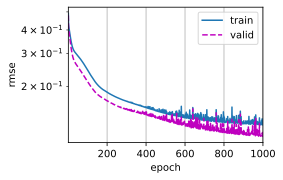

In [83]:
k, num_epochs, lr, weight_decay, batch_size = 5, 1000, 1, 0, 64
train_l, valid_l = k_fold(k, X_train, y_train, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

In [90]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(X_test).detach().numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.119301


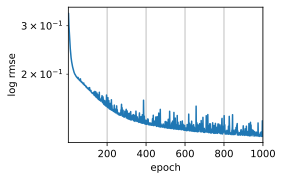

In [99]:
train_and_pred(X_train, X_test, y_train, df_test,
               num_epochs, lr, weight_decay, batch_size)

In [102]:
torch.log(torch.tensor(3))

tensor(1.0986)